In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from models.miniNet import MiniNet
from torchvision import transforms
from utils.calibration import ReliabilityDiagram, TemperatureScaling
from utils.outputEvaluation import binary_acc
from datasets.covidDataset import CovidDataset

## Examine model calibration
Plot reliability diagram

In [2]:
# load best model
net = MiniNet()
net.load_state_dict(torch.load("models/weights/best_model_uncalibrated.pt"))
net.eval()

MiniNet(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (relu4): ReLU()
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
  (relu5): ReLU()
  (fc1): Linear(in_features=3584, out_features=128, bias=True)
  (relu6): ReLU()
  (fc2): Linear(in_features=128, out_features=20, bias=True)
  (relu7): ReLU()
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)

#### Get Predictions for Validation set

In [3]:
# load validation dataset
covid_data_val = CovidDataset("utils", phase='train', transform=transforms.FiveCrop((100,100)))

In [4]:
logits = []
labels = []
for i in range(len(covid_data_val)):
    img, label = covid_data_val[i]
    logits.append(net(img).item())
    labels.append(label.item())

In [5]:
reliability_diagram = ReliabilityDiagram()

In [6]:
positives_per_bin, confidence_per_bin, ece_before, max_ece_before = reliability_diagram(torch.Tensor(logits), torch.Tensor(labels))

In [7]:
print("Calibration error before calibration %1.3f" % ece_before)
print("Maximum calibration error before calibration %1.3f" % max_ece_before)

Calibration error before calibration 2.860
Maximum calibration error before calibration 0.740


### Reliability Diagram

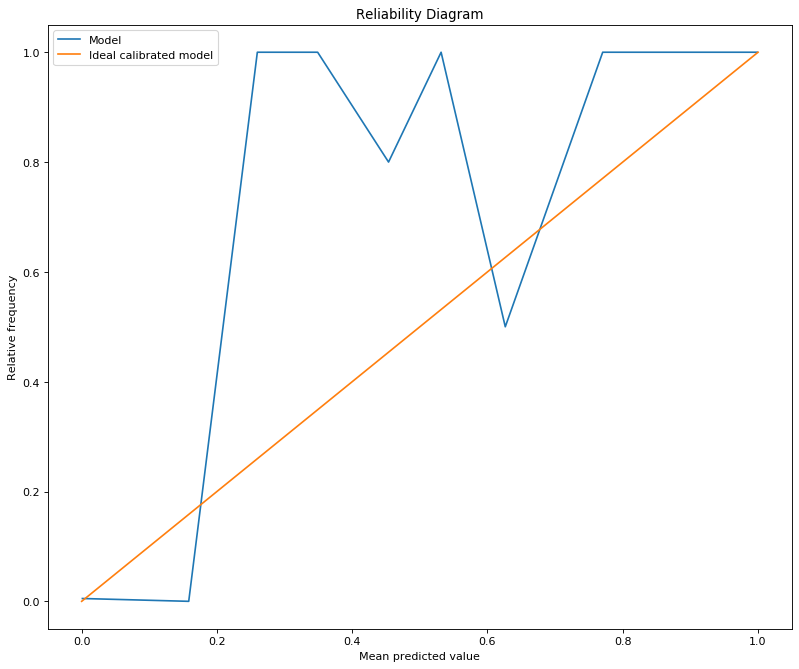

In [8]:
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(confidence_per_bin, positives_per_bin)
plt.plot(np.linspace(0,1),np.linspace(0,1))
plt.legend(["Model", "Ideal calibrated model"])
plt.title("Reliability Diagram")
plt.ylabel("Relative frequency")
plt.xlabel("Mean predicted value")
plt.show()

### Calibrate Model
Calibrate model using temperature scaling and plot reliability diagram again

In [9]:
temperature_scaling = TemperatureScaling(net, covid_data_val)

In [10]:
temperature_scaled_model = temperature_scaling.temperature_scale()

Temperature before scaling: 1.000
Temperature after scaling: 1.451


In [11]:
logits = []
labels = []
for i in range(len(covid_data_val)):
    img, label = covid_data_val[i]
    logits.append(temperature_scaled_model(img).item())
    labels.append(label.item())

In [12]:
reliability_diagram = ReliabilityDiagram()
positives_per_bin, confidence_per_bin, ece_after, max_ece_after = reliability_diagram(torch.Tensor(logits), torch.Tensor(labels))

In [13]:
print("Calibration error after calibration %1.3f" % ece_after)
print("Maximum calibration error after calibration %1.3f" % max_ece_after)

Calibration error after calibration 2.161
Maximum calibration error after calibration 0.635


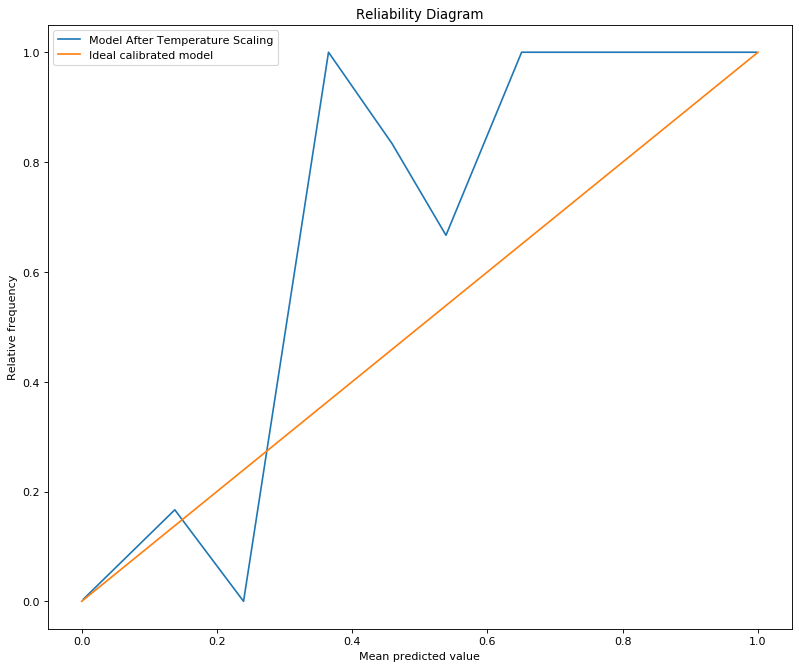

In [14]:
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(confidence_per_bin, positives_per_bin)
plt.plot(np.linspace(0,1),np.linspace(0,1))
plt.legend(["Model After Temperature Scaling", "Ideal calibrated model"])
plt.title("Reliability Diagram")
plt.ylabel("Relative frequency")
plt.xlabel("Mean predicted value")
plt.show()

## Conclusion
Temperature scaling slightly improves the calibration error after training


